In [3]:
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

# custom functions
from plotting_functions.corr_matrix import plot_corr
from plotting_functions.map_scatter import map_scatter

sns.set()

In [4]:
main_data = pd.read_csv('../data/old_datasets/main_dataset.csv')
main_data

,borough,neighborhood,longitude,latitude,population,restaurant_count,N,bars,bbq,breakfast_brunch,...,store,subway_station,supermarket,synagogue,taxi_stand,tourist_attraction,transit_station,travel_agency,university,veterinary_care
0,Bronx,Wakefield,-73.847201,40.894705,21242.0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bronx,Co-op City,-73.829939,40.874294,43752.0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0,9,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0,14,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,20,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
302,Queens,Hammels,-73.805530,40.587338,12295.0,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
303,Queens,Bayswater,-73.765968,40.611322,25029.0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,0,0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0,17,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0


In [5]:
old_data = pd.read_csv('../data/old_datasets/old_dataset.csv', index_col=0)
id_data = old_data
old_data

,id,borough,neighborhood,longitude,latitude,population,number_of_restaurants,average_review_count,average_restaurant_rating,average_price_level,yelp_category
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705,21242.0,13,169,4.0,1,caribbean
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294,43752.0,12,771,4.0,2,delis
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556,11506.0,19,532,4.1,1,caribbean
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437,9287.0,9,297,4.4,1,N
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834,9287.0,14,319,4.0,2,burgers
...,...,...,...,...,...,...,...,...,...,...,...
301,nyu_2451_34572.302,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,20,848,4.3,2,newamerican
302,nyu_2451_34572.303,Queens,Hammels,-73.805530,40.587338,12295.0,17,257,4.3,2,chicken_wings
303,nyu_2451_34572.304,Queens,Bayswater,-73.765968,40.611322,25029.0,0,0,0.0,0,N
304,nyu_2451_34572.305,Queens,Queensbridge,-73.945631,40.756091,6677.0,17,222,4.1,2,tradamerican


In [6]:
# let's get our encoded yelp_types
yelp_types = pd.read_csv('../data/data/yelp_restaurant_type_counts.csv').drop('Unnamed: 0', axis=1)
yelp_types

,caribbean,breakfast_brunch,pizza,burgers,sandwiches,comfortfood,soulfood,grocery,cafes,chinese,...,airportlounges,surfshop,media,shavedice,pretzels,srilankan,southafrican,personalchefs,homedecor,syrian
0,4.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,1.0,4.0,3.0,2.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,3.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
all_features = pd.read_csv('../data/data/all_features_counts_v3.csv', index_col=0).drop(['population', 'id'], axis=1)
all_features

,lodging,restaurant,school,health,bar,church,bank,store,clothing,tourist attraction,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,9,55,26,13,10,60,12,36,19,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,39,26,7,4,25,15,37,34,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,33,16,3,11,23,4,36,13,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,54,27,7,14,5,24,19,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,20,25,9,16,12,23,19,5,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,39,60,60,20,60,37,60,60,60,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,3,44,6,9,8,20,3,33,6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,4,32,15,6,2,18,7,34,12,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,19,59,36,10,19,25,12,36,7,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# New Features

In [8]:
geo_info = main_data.loc[:,:'population']
geo_info

,borough,neighborhood,longitude,latitude,population
0,Bronx,Wakefield,-73.847201,40.894705,21242.0
1,Bronx,Co-op City,-73.829939,40.874294,43752.0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0
...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0
302,Queens,Hammels,-73.805530,40.587338,12295.0
303,Queens,Bayswater,-73.765968,40.611322,25029.0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0


In [9]:
main_features = main_data.loc[:,'restaurant_count':]

In [10]:
### V3 dataset

all_features = pd.concat([geo_info.loc[:,'longitude':'latitude'],all_features], axis=1)

In [11]:
# robust scaler

# scaling
scaler = MinMaxScaler()
main_features_scaled = pd.DataFrame(scaler.fit_transform(all_features), columns=all_features.columns)
main_features_scaled

,longitude,latitude,lodging,restaurant,school,health,bar,church,bank,store,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,0.742705,0.965681,0.150000,0.916667,0.433333,0.216667,0.166667,1.000000,0.200000,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.774806,0.915060,0.083333,0.650000,0.433333,0.116667,0.066667,0.416667,0.250000,0.616667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.778772,0.947950,0.050000,0.550000,0.266667,0.050000,0.183333,0.383333,0.066667,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.634020,0.967497,0.033333,0.900000,0.450000,0.116667,0.233333,0.083333,0.400000,0.316667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.621109,0.956082,0.050000,0.333333,0.416667,0.150000,0.266667,0.200000,0.383333,0.316667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.458337,0.623310,0.650000,1.000000,1.000000,0.333333,1.000000,0.616667,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.820199,0.203378,0.050000,0.733333,0.100000,0.150000,0.133333,0.333333,0.050000,0.550000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.893773,0.262861,0.066667,0.533333,0.250000,0.100000,0.033333,0.300000,0.116667,0.566667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.559654,0.621905,0.316667,0.983333,0.600000,0.166667,0.316667,0.416667,0.200000,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# # scaling
# scaler = StandardScaler()
# features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
# features_scaled

In [13]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(main_features_scaled)

distances, indices = nbrs.kneighbors(main_features_scaled)

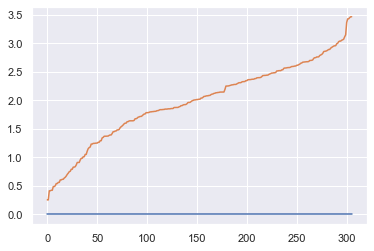

In [14]:
# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [15]:
# between 0.5 and 1.0 seems best
dbscan = DBSCAN(
    eps=1,
    min_samples=5,
    n_jobs=-1
)

In [16]:
# fit and predict
clusters = pd.Series(dbscan.fit_predict(main_features_scaled))
clusters.nunique()

2

# This isn't really working, let's try PCA

In [17]:
# remove restaurant count
main_features_scaled

,longitude,latitude,lodging,restaurant,school,health,bar,church,bank,store,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,0.742705,0.965681,0.150000,0.916667,0.433333,0.216667,0.166667,1.000000,0.200000,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.774806,0.915060,0.083333,0.650000,0.433333,0.116667,0.066667,0.416667,0.250000,0.616667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.778772,0.947950,0.050000,0.550000,0.266667,0.050000,0.183333,0.383333,0.066667,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.634020,0.967497,0.033333,0.900000,0.450000,0.116667,0.233333,0.083333,0.400000,0.316667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.621109,0.956082,0.050000,0.333333,0.416667,0.150000,0.266667,0.200000,0.383333,0.316667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.458337,0.623310,0.650000,1.000000,1.000000,0.333333,1.000000,0.616667,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.820199,0.203378,0.050000,0.733333,0.100000,0.150000,0.133333,0.333333,0.050000,0.550000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.893773,0.262861,0.066667,0.533333,0.250000,0.100000,0.033333,0.300000,0.116667,0.566667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.559654,0.621905,0.316667,0.983333,0.600000,0.166667,0.316667,0.416667,0.200000,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Variance Explained')

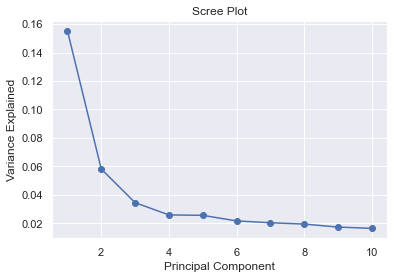

In [18]:
# How many PCs do we want?

pca = PCA(n_components=10)
pca_fit = pca.fit(main_features_scaled)
pca_fit

PC_values = np.arange(pca.n_components_) + 1
PC_values

plt.plot(PC_values, pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

In [19]:
# # 3 is the ideal PCA
# pca = PCA(n_components=3)
# features_pca = pd.DataFrame(pca.fit_transform(main_features_scaled), columns=['PC1','PC2','PC3'])
# features_pca

# Let's try 5
pca = PCA(n_components=5)
features_pca = pd.DataFrame(pca.fit_transform(main_features_scaled), columns=['PC1','PC2','PC3','PC4','PC5'])
features_pca

,PC1,PC2,PC3,PC4,PC5
0,-0.299939,0.806300,-0.274681,-0.278856,0.470470
1,-0.518157,0.534939,-0.132881,0.076055,0.229458
2,-0.538953,0.445996,-0.109848,-0.220285,0.161621
3,-0.538112,-0.179316,0.133599,-0.266408,-0.334315
4,-0.516148,-0.017691,0.358770,-0.114687,-0.521047
...,...,...,...,...,...
301,1.916515,-0.732110,-0.089891,-0.048235,-0.155765
302,-0.552061,-0.352613,-0.136091,-0.256063,-0.092412
303,-0.866517,-0.302152,-0.561784,0.132420,0.002640
304,0.245570,0.018321,0.171835,-0.433437,0.075521


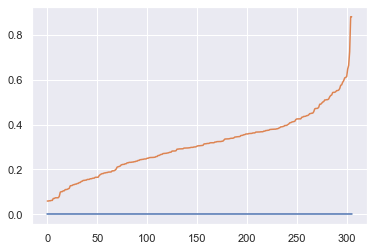

In [20]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_pca)

distances, indices = nbrs.kneighbors(features_pca)

# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [37]:
dbscan = DBSCAN(
    eps=.48,
    min_samples=6,
    n_jobs=-1
)

In [38]:
# fit and predict
clusters = pd.Series(dbscan.fit_predict(features_pca))
clusters.nunique()

6

In [39]:
# add back geo info and clusters
clustered_pca = pd.concat([geo_info, features_pca, clusters], axis=1)
clustered_pca = clustered_pca.rename(columns={0:'cluster'})

In [40]:
clustered_pca

,borough,neighborhood,longitude,latitude,population,PC1,PC2,PC3,PC4,PC5,cluster
0,Bronx,Wakefield,-73.847201,40.894705,21242.0,-0.299939,0.806300,-0.274681,-0.278856,0.470470,-1
1,Bronx,Co-op City,-73.829939,40.874294,43752.0,-0.518157,0.534939,-0.132881,0.076055,0.229458,0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0,-0.538953,0.445996,-0.109848,-0.220285,0.161621,0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0,-0.538112,-0.179316,0.133599,-0.266408,-0.334315,0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0,-0.516148,-0.017691,0.358770,-0.114687,-0.521047,0
...,...,...,...,...,...,...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,1.916515,-0.732110,-0.089891,-0.048235,-0.155765,4
302,Queens,Hammels,-73.805530,40.587338,12295.0,-0.552061,-0.352613,-0.136091,-0.256063,-0.092412,0
303,Queens,Bayswater,-73.765968,40.611322,25029.0,-0.866517,-0.302152,-0.561784,0.132420,0.002640,0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0,0.245570,0.018321,0.171835,-0.433437,0.075521,2


In [41]:
# export for evaluation
clustered_pca.to_csv('../data/evaluation_data/dbscan_v3_clusters.csv')

In [26]:
def DBSCANplot(data=features_pca, eps=2, min_samples=3, map_plot=True):
    dbscan = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    n_jobs=-1
    )
    
    # fit and predict
    clusters = pd.Series(dbscan.fit_predict(data))
    print(clusters.nunique())

    # add back geo info and clusters
    clustered_pca = pd.concat([geo_info, features_pca, clusters], axis=1)
    clustered_pca = clustered_pca.rename(columns={0:'cluster'})

    print(clustered_pca.groupby('cluster').count())
    if map_plot:
        map_scatter(clustered_pca)


    # reduce to 3D for graphing
    pca = PCA(n_components=2)
    graph_pca = pd.DataFrame(pca.fit_transform(main_features_scaled), columns=['PC1','PC2'])
    graph_pca = pd.concat([graph_pca,clusters], axis=1)
    graph_pca = graph_pca.rename(columns={0:'cluster'})


    fig = px.scatter(graph_pca, x='PC1', y='PC2',
              color='cluster')
    fig.show()

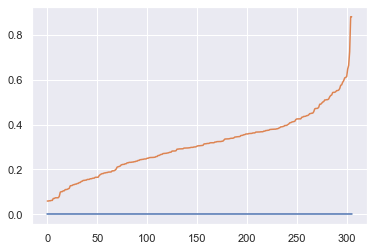

In [27]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_pca)

distances, indices = nbrs.kneighbors(features_pca)

# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [35]:
# Define variable options
eps_options = np.arange(.48,.51,1)
min_options = np.arange(2,10,1)

In [36]:
for eps in eps_options:
    for min in min_options:
        print('eps:' + str(eps))
        print('min:' + str(min))
        DBSCANplot(features_pca, eps, min, map_plot=False)

eps:0.48
min:2
11
         borough  neighborhood  longitude  latitude  population  PC1  PC2  \
cluster                                                                     
-1            33            33         33        33          33   33   33   
 0             3             3          3         3           3    3    3   
 1           232           232        232       232         232  232  232   
 2             2             2          2         2           2    2    2   
 3             2             2          2         2           2    2    2   
 4             3             3          3         3           3    3    3   
 5             2             2          2         2           2    2    2   
 6             2             2          2         2           2    2    2   
 7            23            23         23        23          23   23   23   
 8             2             2          2         2           2    2    2   
 9             2             2          2         2       

eps:0.48
min:3
5
         borough  neighborhood  longitude  latitude  population  PC1  PC2  \
cluster                                                                     
-1            45            45         45        45          45   45   45   
 0           232           232        232       232         232  232  232   
 1             3             3          3         3           3    3    3   
 2             3             3          3         3           3    3    3   
 3            23            23         23        23          23   23   23   

         PC3  PC4  PC5  
cluster                 
-1        45   45   45  
 0       232  232  232  
 1         3    3    3  
 2         3    3    3  
 3        23   23   23  


eps:0.48
min:4
3
         borough  neighborhood  longitude  latitude  population  PC1  PC2  \
cluster                                                                     
-1            53            53         53        53          53   53   53   
 0           230           230        230       230         230  230  230   
 1            23            23         23        23          23   23   23   

         PC3  PC4  PC5  
cluster                 
-1        53   53   53  
 0       230  230  230  
 1        23   23   23  


eps:0.48
min:5
4
         borough  neighborhood  longitude  latitude  population  PC1  PC2  \
cluster                                                                     
-1            63            63         63        63          63   63   63   
 0           184           184        184       184         184  184  184   
 1            36            36         36        36          36   36   36   
 2            23            23         23        23          23   23   23   

         PC3  PC4  PC5  
cluster                 
-1        63   63   63  
 0       184  184  184  
 1        36   36   36  
 2        23   23   23  


eps:0.48
min:6
6
         borough  neighborhood  longitude  latitude  population  PC1  PC2  \
cluster                                                                     
-1            66            66         66        66          66   66   66   
 0           157           157        157       157         157  157  157   
 1            24            24         24        24          24   24   24   
 2            19            19         19        19          19   19   19   
 3            17            17         17        17          17   17   17   
 4            23            23         23        23          23   23   23   

         PC3  PC4  PC5  
cluster                 
-1        66   66   66  
 0       157  157  157  
 1        24   24   24  
 2        19   19   19  
 3        17   17   17  
 4        23   23   23  


eps:0.48
min:7
6
         borough  neighborhood  longitude  latitude  population  PC1  PC2  \
cluster                                                                     
-1            79            79         79        79          79   79   79   
 0           155           155        155       155         155  155  155   
 1            24            24         24        24          24   24   24   
 2            15            15         15        15          15   15   15   
 3            22            22         22        22          22   22   22   
 4            11            11         11        11          11   11   11   

         PC3  PC4  PC5  
cluster                 
-1        79   79   79  
 0       155  155  155  
 1        24   24   24  
 2        15   15   15  
 3        22   22   22  
 4        11   11   11  


eps:0.48
min:8
8
         borough  neighborhood  longitude  latitude  population  PC1  PC2  \
cluster                                                                     
-1            98            98         98        98          98   98   98   
 0           127           127        127       127         127  127  127   
 1            22            22         22        22          22   22   22   
 2            15            15         15        15          15   15   15   
 3            14            14         14        14          14   14   14   
 4            14            14         14        14          14   14   14   
 5            11            11         11        11          11   11   11   
 6             5             5          5         5           5    5    5   

         PC3  PC4  PC5  
cluster                 
-1        98   98   98  
 0       127  127  127  
 1        22   22   22  
 2        15   15   15  
 3        14   14   14  
 4        14   14   14  
 5        11

eps:0.48
min:9
5
         borough  neighborhood  longitude  latitude  population  PC1  PC2  \
cluster                                                                     
-1           141           141        141       141         141  141  141   
 0           124           124        124       124         124  124  124   
 1            20            20         20        20          20   20   20   
 2            12            12         12        12          12   12   12   
 3             9             9          9         9           9    9    9   

         PC3  PC4  PC5  
cluster                 
-1       141  141  141  
 0       124  124  124  
 1        20   20   20  
 2        12   12   12  
 3         9    9    9  


In [34]:
# With PC3, best values are eps:1.6 and min 4
DBSCANplot(features_pca, .48,6)

6
         borough  neighborhood  longitude  latitude  population  PC1  PC2  \
cluster                                                                     
-1            66            66         66        66          66   66   66   
 0           157           157        157       157         157  157  157   
 1            24            24         24        24          24   24   24   
 2            19            19         19        19          19   19   19   
 3            17            17         17        17          17   17   17   
 4            23            23         23        23          23   23   23   

         PC3  PC4  PC5  
cluster                 
-1        66   66   66  
 0       157  157  157  
 1        24   24   24  
 2        19   19   19  
 3        17   17   17  
 4        23   23   23  


In [67]:
# With PC3, best values are eps:1.6 and min 4
DBSCANplot(features_pca, .45,6)

9


In [28]:
num_top_venues = 5

# We need to remove the venue counts, it's distorting the data

### Google

In [29]:
features_1km.sum().sort_values(ascending=False)[:30].keys()

NameError: name 'features_1km' is not defined

In [ ]:
['lodging', 'restaurant', 'school', 'health', 'bar', 'church', 'bank', 'store',
       'clothing', 'tourist attraction', 'gym', 'lawyer', 'bakery',
       'cafe', 'department store', 'university', 'local government office',
       'electronics store', 'park', 'drugstore', 'supermarket']